In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
# from tomlkit import boolean
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data import Image_loader
import lib

Load Images

In [14]:
img_obj = Image_loader("Datasets\\castle-P30")
enable_bundle_adjustment = False

Finding keypoints from 2 images

In [3]:
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
pose_array = img_obj.K.ravel()
transform_matrix_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
transform_matrix_1 = np.empty((3, 4))

pose_0 = np.matmul(img_obj.K, transform_matrix_0)
pose_1 = np.empty((3, 4)) 
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))

image_0 = img_obj.downscale_image(cv2.imread(img_obj.image_list[0]))
image_1 = img_obj.downscale_image(cv2.imread(img_obj.image_list[1]))

feature_0, feature_1 = lib.find_keypoints(image_0, image_1)

Calculating Essential and Rotation Matrixes

In [4]:
essential_matrix, em_mask = cv2.findEssentialMat(feature_0, feature_1, img_obj.K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
feature_0 = feature_0[em_mask.ravel() == 1]
feature_1 = feature_1[em_mask.ravel() == 1]


_, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, feature_0, feature_1, img_obj.K)
feature_0 = feature_0[em_mask.ravel() > 0]
feature_1 = feature_1[em_mask.ravel() > 0]
transform_matrix_1[:3, :3] = np.matmul(rot_matrix, transform_matrix_0[:3, :3])
transform_matrix_1[:3, 3] = transform_matrix_0[:3, 3] + np.matmul(transform_matrix_0[:3, :3], tran_matrix.ravel())

Triangulation

In [5]:
pose_1 = np.matmul(img_obj.K, transform_matrix_1)

feature_0, feature_1, points_3d = lib.triangulation(pose_0, pose_1, feature_0, feature_1)

In [6]:
error, points_3d = lib.reprojection_error(points_3d, feature_1, transform_matrix_1, img_obj.K, homogenity = 1)
print("REPROJECTION ERROR: ", error)


REPROJECTION ERROR:  0.006572311839443069


PnP

In [7]:
_, _, feature_1, points_3d, _ = lib.PnP(points_3d, feature_1, img_obj.K, np.zeros((5, 1), dtype=np.float32), feature_0, initial=1)

In [8]:
total_images = len(img_obj.image_list) - 2 
pose_array = np.hstack((np.hstack((pose_array, pose_0.ravel())), pose_1.ravel()))

  0%|          | 0/28 [00:00<?, ?it/s]

 Shape New Array (1075, 2) (1075, 2)
Reprojection Error:  1.250388848252236


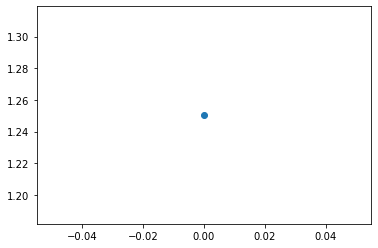

  4%|▎         | 1/28 [00:00<00:24,  1.10it/s]

 Shape New Array (858, 2) (858, 2)
Reprojection Error:  2.9059230243830276


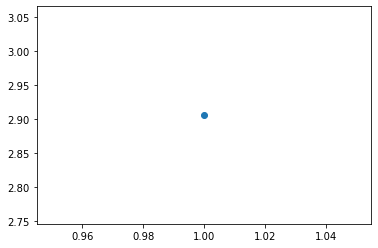

  7%|▋         | 2/28 [00:01<00:23,  1.10it/s]

 Shape New Array (1479, 2) (1479, 2)
Reprojection Error:  0.29458859234723156


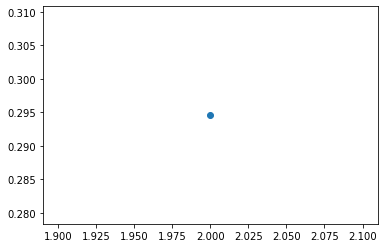

 11%|█         | 3/28 [00:02<00:23,  1.08it/s]

 Shape New Array (990, 2) (990, 2)
Reprojection Error:  1.1359981150773097


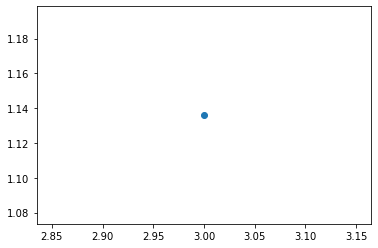

 14%|█▍        | 4/28 [00:03<00:22,  1.08it/s]

 Shape New Array (1039, 2) (1039, 2)
Reprojection Error:  0.9270037940857192


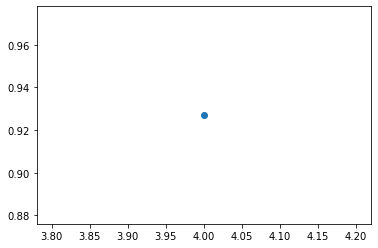

 18%|█▊        | 5/28 [00:04<00:21,  1.06it/s]

 Shape New Array (563, 2) (563, 2)
Reprojection Error:  1.9407768580982538


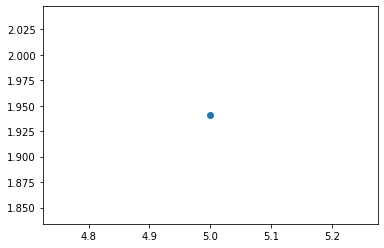

 21%|██▏       | 6/28 [00:05<00:20,  1.07it/s]

 Shape New Array (1207, 2) (1207, 2)
Reprojection Error:  1.065391029027667


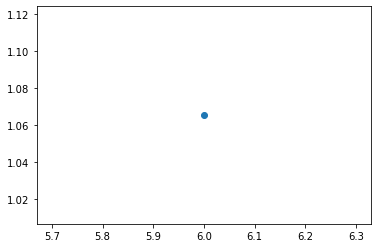

 25%|██▌       | 7/28 [00:06<00:19,  1.09it/s]

 Shape New Array (1194, 2) (1194, 2)
Reprojection Error:  3.919670395083307


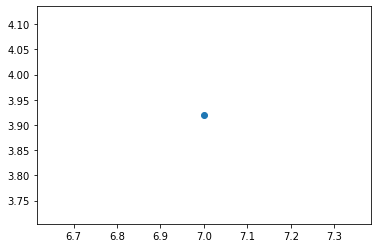

 29%|██▊       | 8/28 [00:07<00:18,  1.08it/s]

 Shape New Array (772, 2) (772, 2)
Reprojection Error:  1.065226454347029


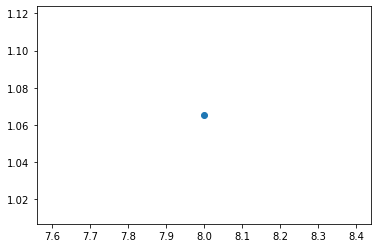

 32%|███▏      | 9/28 [00:08<00:17,  1.07it/s]

 Shape New Array (725, 2) (725, 2)
Reprojection Error:  2.310624600901623


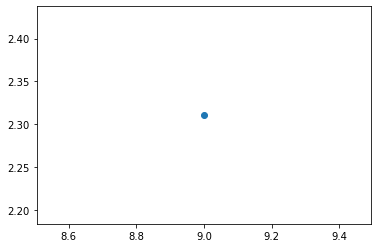

 36%|███▌      | 10/28 [00:09<00:16,  1.09it/s]

 Shape New Array (943, 2) (943, 2)
Reprojection Error:  1.4085117715148592


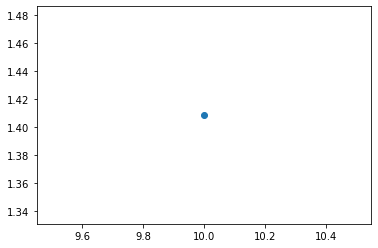

 39%|███▉      | 11/28 [00:10<00:15,  1.11it/s]

 Shape New Array (687, 2) (687, 2)
Reprojection Error:  3.398731453345431


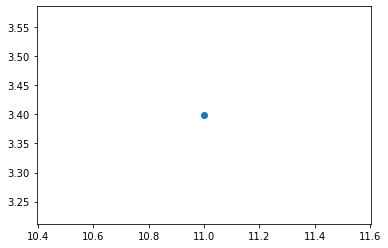

 43%|████▎     | 12/28 [00:11<00:14,  1.09it/s]

 Shape New Array (701, 2) (701, 2)
Reprojection Error:  5.0627694031200745


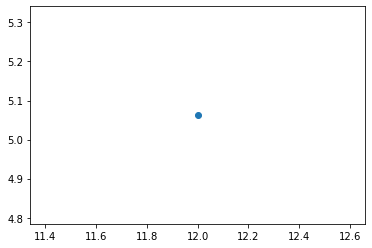

 46%|████▋     | 13/28 [00:11<00:13,  1.13it/s]

 Shape New Array (552, 2) (552, 2)
Reprojection Error:  3.134348356791925


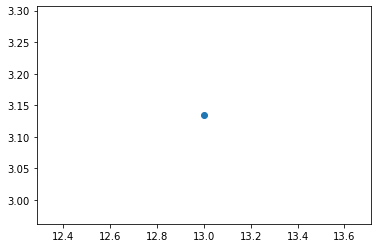

 50%|█████     | 14/28 [00:12<00:12,  1.15it/s]

 Shape New Array (647, 2) (647, 2)
Reprojection Error:  5.5063456755150355


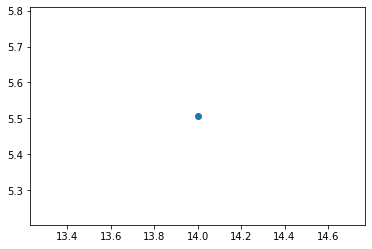

 54%|█████▎    | 15/28 [00:13<00:10,  1.19it/s]

 Shape New Array (310, 2) (310, 2)
Reprojection Error:  8.785438436728828


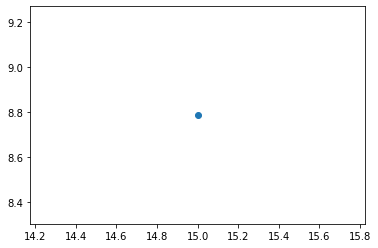

 57%|█████▋    | 16/28 [00:14<00:09,  1.20it/s]

 Shape New Array (188, 2) (188, 2)
Reprojection Error:  3.4816884321187076


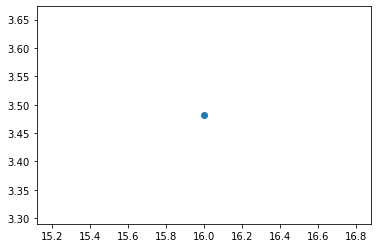

 61%|██████    | 17/28 [00:15<00:08,  1.23it/s]

 Shape New Array (358, 2) (358, 2)
Reprojection Error:  1.5838459562913894


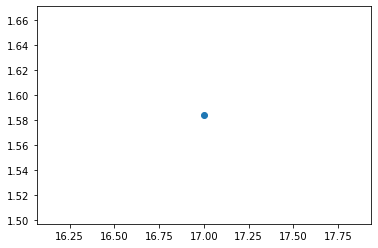

 64%|██████▍   | 18/28 [00:15<00:08,  1.23it/s]

 Shape New Array (502, 2) (502, 2)
Reprojection Error:  18.841047152817332


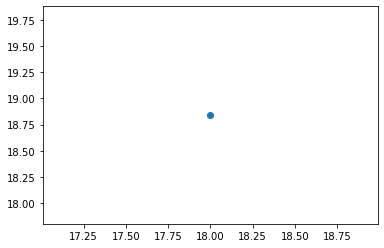

 68%|██████▊   | 19/28 [00:16<00:07,  1.22it/s]

 Shape New Array (728, 2) (728, 2)
Reprojection Error:  104.0593866176987


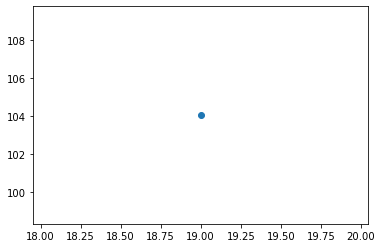

 71%|███████▏  | 20/28 [00:17<00:06,  1.21it/s]

 Shape New Array (572, 2) (572, 2)
Reprojection Error:  111.02602721085293


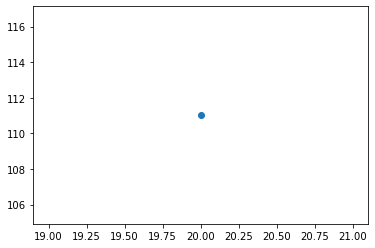

 75%|███████▌  | 21/28 [00:18<00:05,  1.23it/s]

 Shape New Array (304, 2) (304, 2)
Reprojection Error:  2.129634421712359


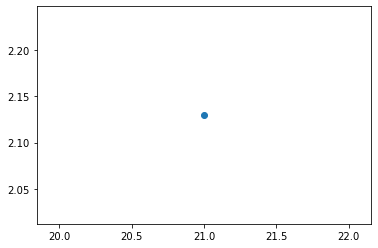

 79%|███████▊  | 22/28 [00:19<00:04,  1.22it/s]

 Shape New Array (620, 2) (620, 2)
Reprojection Error:  1.7944972885367543


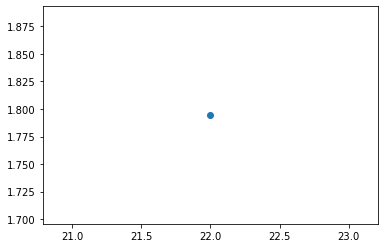

 82%|████████▏ | 23/28 [00:20<00:04,  1.20it/s]

 Shape New Array (606, 2) (606, 2)
Reprojection Error:  37.03931535889889


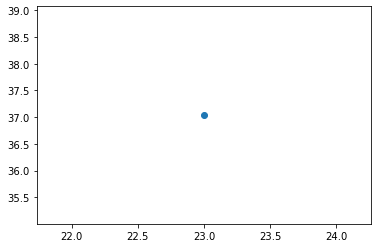

 86%|████████▌ | 24/28 [00:20<00:03,  1.22it/s]

 Shape New Array (667, 2) (667, 2)
Reprojection Error:  107.44104364332586


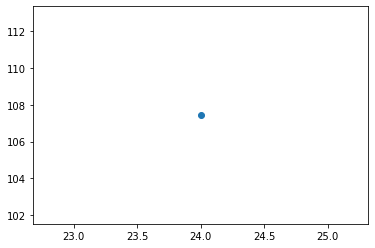

 89%|████████▉ | 25/28 [00:21<00:02,  1.22it/s]

 Shape New Array (693, 2) (693, 2)
Reprojection Error:  0.5139078080868782


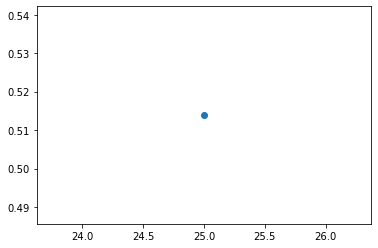

 93%|█████████▎| 26/28 [00:22<00:01,  1.23it/s]

 Shape New Array (636, 2) (636, 2)
Reprojection Error:  0.8692902450162762


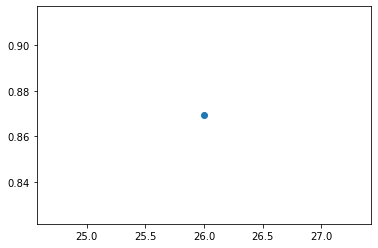

 96%|█████████▋| 27/28 [00:23<00:00,  1.24it/s]

 Shape New Array (252, 2) (252, 2)
Reprojection Error:  2.548209137828322


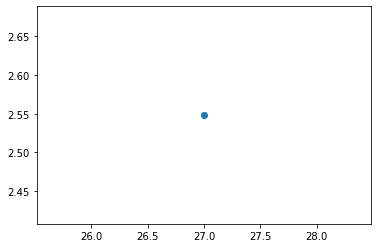

100%|██████████| 28/28 [00:24<00:00,  1.16it/s]


In [9]:
threshold = 0.5
for i in tqdm(range(total_images)):
    image_2 = img_obj.downscale_image(cv2.imread(img_obj.image_list[i + 2]))
    features_cur, features_2 = lib.find_keypoints(image_1, image_2)

    if i != 0:
        feature_0, feature_1, points_3d = lib.triangulation(pose_0, pose_1, feature_0, feature_1)
        feature_1 = feature_1.T
        points_3d = cv2.convertPointsFromHomogeneous(points_3d.T)
        points_3d = points_3d[:, 0, :]
    

    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = lib.common_points(feature_1, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    rot_matrix, tran_matrix, cm_points_2, points_3d, cm_points_cur = lib.PnP(points_3d[cm_points_0], cm_points_2, img_obj.K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
    transform_matrix_1 = np.hstack((rot_matrix, tran_matrix))
    pose_2 = np.matmul(img_obj.K, transform_matrix_1)

    error, points_3d = lib.reprojection_error(points_3d, cm_points_2, transform_matrix_1, img_obj.K, homogenity = 0)

    
    cm_mask_0, cm_mask_1, points_3d = lib.triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
    error, points_3d = lib.reprojection_error(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 1)
    print("Reprojection Error: ", error)
    pose_array = np.hstack((pose_array, pose_2.ravel()))
    # takes a long time to run

    if enable_bundle_adjustment:
        points_3d, cm_mask_1, transform_matrix_1 = lib.bundle_adjustment(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, threshold)
        pose_2 = np.matmul(img_obj.K, transform_matrix_1)
        error, points_3d = lib.reprojection_error(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 0)
        print("Bundle Adjusted error: ",error)
        total_points = np.vstack((total_points, points_3d))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([image_2[l[1], l[0]] for l in points_left])
        total_colors = np.vstack((total_colors, color_vector))
    else:
        total_points = np.vstack((total_points, points_3d[:, 0, :]))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([image_2[l[1], l[0]] for l in points_left.T])
        total_colors = np.vstack((total_colors, color_vector)) 
    



    transform_matrix_0 = np.copy(transform_matrix_1)
    pose_0 = np.copy(pose_1)
    plt.scatter(i, error)
    plt.pause(0.05)

    image_0 = np.copy(image_1)
    image_1 = np.copy(image_2)
    feature_0 = np.copy(features_cur)
    feature_1 = np.copy(features_2)
    pose_1 = np.copy(pose_2)
    cv2.imshow(img_obj.image_list[0].split('\\')[-2], image_2)
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cv2.destroyAllWindows()


Saving Results

In [17]:
print("Printing to .ply file")
print(total_points.shape, total_colors.shape)

img_obj.to_ply(total_points, total_colors)
print("Completed Exiting ...")
np.savetxt(img_obj.path + '\\res\\' + img_obj.image_list[0].split('\\')[-2]+'_pose_array.csv', pose_array, delimiter = '\n')

Printing to .ply file
(19869, 3) (19869, 3)
c:\Users\01150138\Desktop\informatyka mgr\SWIZ\projekt\SWIZ
(19869, 3) (19869, 3)


NameError: name 'img_obj' is not defined